# Acceptance map that "ruins" GENIE samples to mimic the detector

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [90]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/Likelihood/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'

# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
Nevents = len(selected_events_tightFV)
print Nevents,'selected pairs in data in tight FV'

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
applied cuts to data
350 selected pairs in data
182 selected pairs in data in tight FV


In [5]:
# ----------------------------------------------------------
def find_x_poly(poly,y0,xmin=0,xmax=2):
    roots = (poly - y0).roots
    x_poly=-1
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly
# ----------------------------------------------------------

# afro GENIE samples with different $m_A$

In [6]:
sns.set(style='white');
mA_array = [0.6,0.7,0.8,0.9,0.95,0.99,1.05,1.1,1.2,1.3,1.4] # S.Dytman: GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)
mA_colors= ['red','blue','forestgreen','purple','orange','pink','teal','yellow','black']

In [7]:
genie_CC1p0pi = dict()
for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

28507 CC1p0π events in GENIE samples with mA=0.60
30599 CC1p0π events in GENIE samples with mA=0.70
32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34543 CC1p0π events in GENIE samples with mA=0.95
34849 CC1p0π events in GENIE samples with mA=0.99
35749 CC1p0π events in GENIE samples with mA=1.05
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38042 CC1p0π events in GENIE samples with mA=1.30
38810 CC1p0π events in GENIE samples with mA=1.40


# estimate the PDF of the GENIE's $Q^2$ distributions assuming a Gaussian kernel 
in order to obtain the probability distribution function for each sample and to compute the Likelihood
$$ {\displaystyle {\hat {\ell }}(\theta \,;x)={\frac {1}{n}}\sum _{i=1}^{n}\ln f(x_{i}\mid \theta ),} $$
where $f(x_{i}\mid \theta )$ is the PDF assuming the parameter $\theta$

In [98]:
var,x_label='Q2',r'$Q^2$ (GeV/c)$^2$'
Q2_cut = (0.1,0.6)
data_in_cut = selected_events_tightFV[(selected_events_tightFV['reco_Q2'] > Q2_cut[0])
                                          &(selected_events_tightFV['reco_Q2'] < Q2_cut[1])]

In [99]:
debug=0
from superplot.statslib.kde import gaussian_kde
LL_df = pd.DataFrame(columns={'mA','LL'})
log_f_i=dict()
LLmax = -1000
for mA in mA_array:
    var_array = np.array(genie_CC1p0pi[mA]['Q2'])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
    f = pdf(data_in_cut['reco_Q2'])    
    LL = np.sum(np.log(f))    
    if LL>LLmax: LLmax=LL    
    LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL,'LL/n':LL/len(f),'-LL':-LL},index=[mA]))    
    if debug:
        print 'np.min(f):',np.min(f)
        print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))
        print 'LL:',LL
LL_df['-ln(L/Lmax)'] = -(LL_df['LL']-LLmax)

x_MLE_dw: 0.81387364267 ,x_MLE_up: 1.29088311314


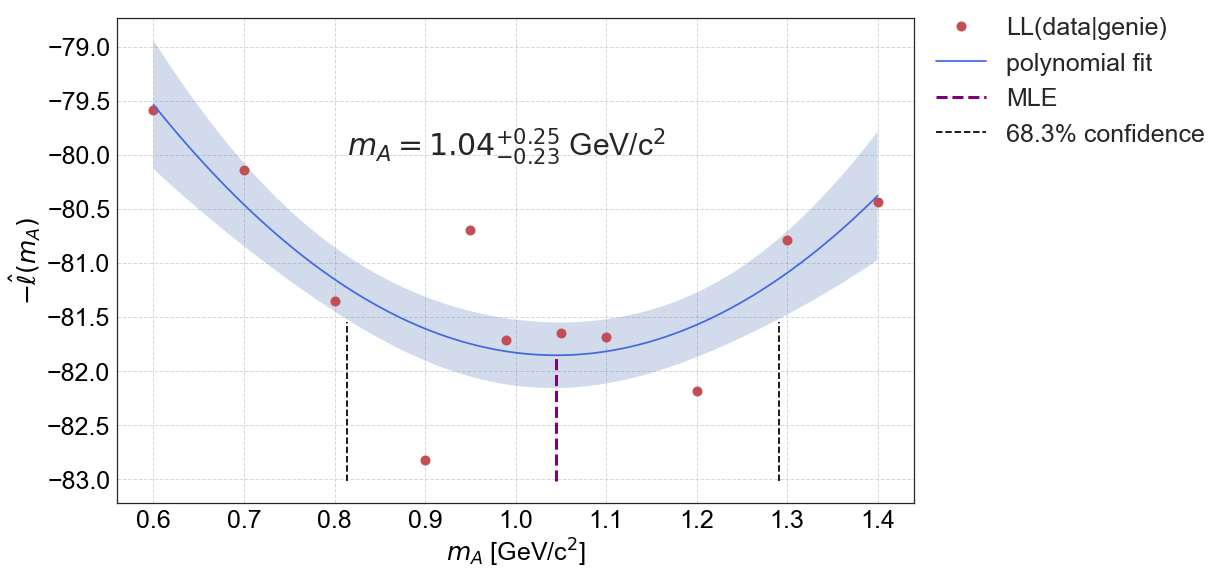

In [112]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
x,y = LL_df['mA'] , LL_df['-LL']
deg = 2 # degree of polynomial
p,cov = np.polyfit(x,y,deg=deg,cov=True)
poly = np.poly1d(p)    

plt.plot( x,y , 'ro',markersize=10,linewidth=2,label='LL(data|genie)')
x_poly = linspace(0.6,1.4,100)
plt.plot(x_poly,poly(x_poly),'-',color='royalblue',label='polynomial fit')    

# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([x_poly**(deg-i) for i in range(deg+1)]).T
Cov_poly = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_poly = np.sqrt(np.diag(Cov_poly))  # Standard deviations are sqrt of diagonal
poly_up = np.poly1d(np.polyfit(x_poly,poly(x_poly)+sig_poly,deg=deg))
poly_dw = np.poly1d(np.polyfit(x_poly,poly(x_poly)-sig_poly,deg=deg))
ax.fill_between(x_poly, poly(x_poly)+sig_poly, poly(x_poly)-sig_poly, alpha=.25)

MLE = np.min(poly(x_poly))
x_MLE = find_x_poly(poly,MLE,xmin=0.6,xmax=1.4)

TT_x_MLE = np.vstack([np.array([x_MLE])**(deg-i) for i in range(deg+1)]).T
Cov_MLE = np.dot(TT_x_MLE, np.dot(cov, TT_x_MLE.T)) # C_y = TT*C_z*TT.T
sig_MLE = np.sqrt(np.diag(Cov_MLE))  # Standard deviations are sqrt of diagonal
MLE_top = MLE + sig_MLE

ymin = np.min(ax.get_ylim())
plt.plot([x_MLE,x_MLE],[ymin,MLE],'--',linewidth=3,color='purple',label='MLE')
MLE = poly(x_MLE)
x_MLE_dw = find_x_poly(poly_dw,MLE_top,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
x_MLE_up = find_x_poly(poly_dw,MLE_top,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
print 'x_MLE_dw:',x_MLE_dw,",x_MLE_up:",x_MLE_up
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[ymin,MLE_top],'--'
        ,[x_MLE_up,x_MLE_up],[ymin,MLE_top],'--'
#         ,[x_MLE_dw,x_MLE_up],[MLE_top,MLE_top],'-'
        ,color='black',label='68.3% confidence')
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-{\hat {\ell }}(m_{A})$',do_add_grid=True)
plt.text(x_MLE_dw,-80,r'$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err),fontsize=30)
leg=plt.legend(bbox_to_anchor=(1.0,1.05),loc=2,fontsize=25)
# save_figure(figures_path+'Likelihood_Q2.pdf')
plt.tight_layout()
fig.savefig(figures_path+'Likelihood_Q2.pdf', bbox_inches='tight') 

# estimate the PDF of the GENIE's $p_p$ distributions assuming a Gaussian kernel 

In [113]:
var,x_label='Pp',r'$p_p$ (GeV/c)'
Pp_cut = (0.2,0.9)
data_in_cut = selected_events[(selected_events['reco_Pp'] > Pp_cut[0])
                              &(selected_events['reco_Pp'] < Pp_cut[1])]

In [114]:
debug=0
LL_df = pd.DataFrame(columns={'mA','LL'})
LLmax = -1000
for mA in mA_array:
    var_array = np.array(genie_CC1p0pi[mA]['Pp'])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
    f = pdf(data_in_cut['reco_Pp'])
    LL = np.sum(np.log(f))
    if LL>LLmax: LLmax=LL
    LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL,'LL/n':LL/len(f),'-LL':-LL},index=[mA]))    
    if debug:
        print 'np.min(f):',np.min(f)
        print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))
        print 'LL:',LL
    # LL_df
LL_df['-ln(L/Lmax)'] = -(LL_df['LL']-LLmax)
print 'done'    

done


x_MLE_dw: 0.907480291854 ,x_MLE_up: 1.1830793886
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/Likelihood/Likelihood_Pp.pdf


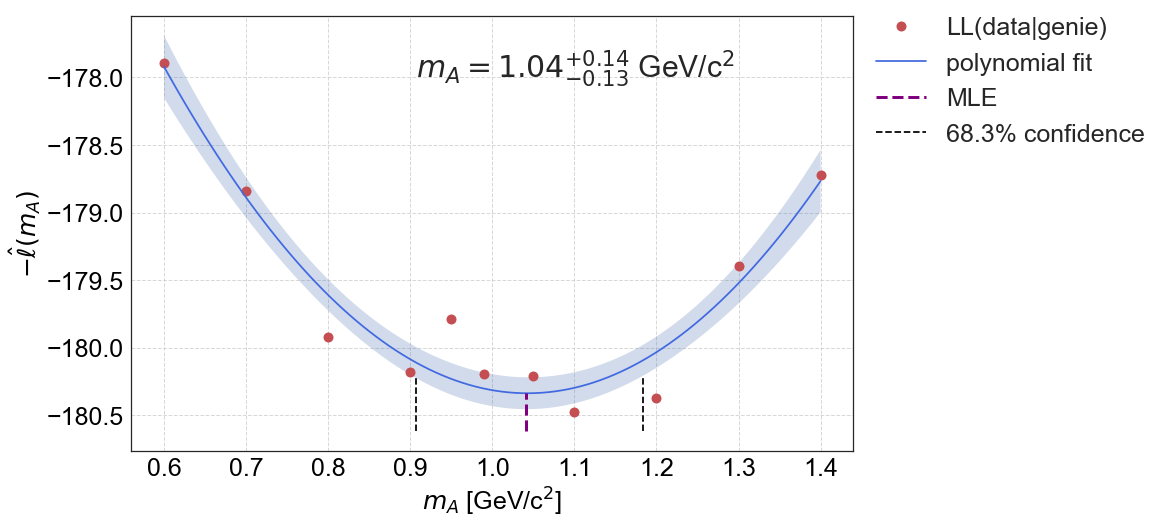

In [115]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
LL_df = LL_results['%.2f<Pp<%.2f'%(Pp_cut[0],Pp_cut[1])]
x,y = LL_df['mA'] , LL_df['-LL']
deg = 2 # degree of polynomial
p,cov = np.polyfit(x,y,deg=deg,cov=True)
poly = np.poly1d(p)    

plt.plot( x,y , 'ro',markersize=10,linewidth=2,label='LL(data|genie)')
x_poly = linspace(0.6,1.4,100)
plt.plot(x_poly,poly(x_poly),'-',color='royalblue',label='polynomial fit')    

# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([x_poly**(deg-i) for i in range(deg+1)]).T
Cov_poly = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_poly = np.sqrt(np.diag(Cov_poly))  # Standard deviations are sqrt of diagonal
poly_up = np.poly1d(np.polyfit(x_poly,poly(x_poly)+sig_poly,deg=deg))
poly_dw = np.poly1d(np.polyfit(x_poly,poly(x_poly)-sig_poly,deg=deg))
ax.fill_between(x_poly, poly(x_poly)+sig_poly, poly(x_poly)-sig_poly, alpha=.25)

MLE = np.min(poly(x_poly))
x_MLE = find_x_poly(poly,MLE,xmin=0.6,xmax=1.4)

TT_x_MLE = np.vstack([np.array([x_MLE])**(deg-i) for i in range(deg+1)]).T
Cov_MLE = np.dot(TT_x_MLE, np.dot(cov, TT_x_MLE.T)) # C_y = TT*C_z*TT.T
sig_MLE = np.sqrt(np.diag(Cov_MLE))  # Standard deviations are sqrt of diagonal
MLE_top = MLE + sig_MLE

ymin = np.min(ax.get_ylim())
plt.plot([x_MLE,x_MLE],[ymin,MLE],'--',linewidth=3,color='purple',label='MLE')
MLE = poly(x_MLE)
x_MLE_dw = find_x_poly(poly_dw,MLE_top,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
x_MLE_up = find_x_poly(poly_dw,MLE_top,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
print 'x_MLE_dw:',x_MLE_dw,",x_MLE_up:",x_MLE_up
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[ymin,MLE_top],'--'
        ,[x_MLE_up,x_MLE_up],[ymin,MLE_top],'--'
#         ,[x_MLE_dw,x_MLE_up],[MLE_top,MLE_top],'-'
        ,color='black',label='68.3% confidence')
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-{\hat {\ell }}(m_{A})$',do_add_grid=True)
plt.text(x_MLE_dw,-178,r'$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err),fontsize=30)
plt.legend(bbox_to_anchor=(1.0,1.05),loc=2,fontsize=25)
save_figure(figures_path+'Likelihood_Pp.pdf')
fig.savefig(figures_path+'Likelihood_Pp.pdf', bbox_inches='tight') 

In [ ]:
debug=0
LL_results = dict()
Pp_cut_array = [(0.2,0.9)]
for Pp_cut in Pp_cut_array:
    data_in_cut = selected_events[(selected_events['reco_Pp'] > Pp_cut[0])
                                  &(selected_events['reco_Pp'] < Pp_cut[1])]    
    LL_df = pd.DataFrame(columns={'mA','LL'})
    LLmax = -1000
    for mA in mA_array:
        var_array = np.array(genie_CC1p0pi[mA][var])
        weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
        pdf = gaussian_kde(var_array,weights=weights)
        f = pdf(data_in_cut['reco_Pp'])
        LL = np.sum(np.log(f))
        if LL>LLmax: LLmax=LL
        LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL,'LL/n':LL/len(f),'-LL':-LL},index=[mA]))    
        if debug:
            print 'np.min(f):',np.min(f)
            print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))
            print 'LL:',LL
    # LL_df
    LL_df['-ln(L/Lmax)'] = -(LL_df['LL']-LLmax)
    LL_results['%.2f<Pp<%.2f'%(Pp_cut[0],Pp_cut[1])] = LL_df
print 'done'    

x_MLE_dw: 0.758064037632 ,x_MLE_up: 1.32780646885


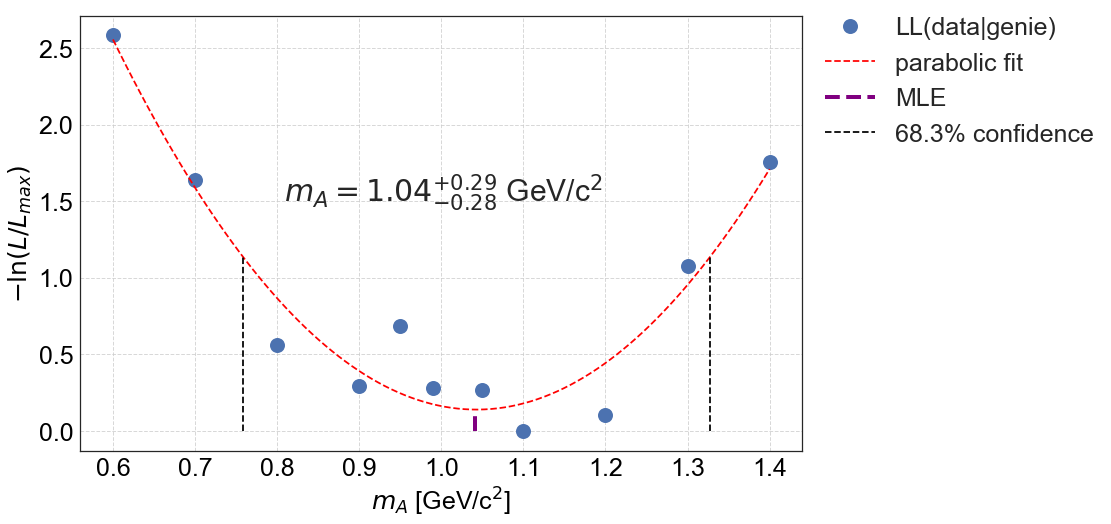

In [13]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
for Pp_cut in Pp_cut_array:
    LL_df = LL_results['%.2f<Pp<%.2f'%(Pp_cut[0],Pp_cut[1])]
    x,y = LL_df['mA'] , LL_df['-ln(L/Lmax)']
    z = np.polyfit(x,y,deg=2)
    poly = np.poly1d(z)    
    plt.plot( LL_df['mA'] , LL_df['-ln(L/Lmax)'] , 'o',markersize=15
             ,linewidth=2,label='LL(data|genie)')#'$%.2f<p_p<%.2f$'%(Pp_cut[0],Pp_cut[1])
    x_poly = linspace(0.6,1.4,100)
    plt.plot(x_poly,poly(x_poly),'--',color='red',label='parabolic fit')    
    x_MLE = find_x_poly(poly,np.min(poly(x_poly)),xmin=0.6,xmax=1.4)
    plt.plot([x_MLE,x_MLE],[0,poly(x_MLE)],'--',linewidth=4,color='purple',label='MLE')
    MLE = poly(x_MLE)
    x_MLE_dw = find_x_poly(poly,MLE+1,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
    x_MLE_up = find_x_poly(poly,MLE+1,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
    print 'x_MLE_dw:',x_MLE_dw,",x_MLE_up:",x_MLE_up
    plt.plot(        
            [x_MLE_dw,x_MLE_dw],[0,poly(x_MLE_dw)],'--'
            ,[x_MLE_up,x_MLE_up],[0,poly(x_MLE_up)],'--'
    #        ,[x_MLE_dw,x_MLE_up],[1,1],'--'             
            ,color='black',label='68.3% confidence')
    set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-\ln(L/L_{max})$',do_add_grid=True)
    plt.text(x_MLE_dw+0.05,1.5,r'$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err),fontsize=30)

set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-\ln(L/L_{max})$',do_add_grid=True)
plt.legend(bbox_to_anchor=(1.0,1.05),loc=2,fontsize=25)